In [100]:
# reuqire backage
import plotly
import pandas
import graphviz 
import imblearn
import pydotplus
import numpy as np
from collections import Counter
from mlxtend.plotting import plot_decision_regions

#matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#sklearn
import sklearn
import sklearn.model_selection
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier


**Read the CSV file**

In [2]:
#read files from csv via pandas
df = pandas.read_csv("Pokemon.csv", header = 0)
df = df.drop(columns = ["#"]) # drop id
df["Legendary"] = df["Legendary"].astype('int32') # convert the Legendary boolean to 1 or 0


**EDA works**
- Combines type 1 and type 2 features
- Convert the type into one-hot encoding
- Adding attack damage and defense value
- Drop non-effect features

In [ ]:
# TBC
# duplicate the type 2 to another column
type2 = df.loc[df['Type 2'].notnull()] #select the non-null feature 2
type2 = type2.reset_index(drop=True)
type2["Type 1"] = type2["Type 2"]
type2 = type2.drop(columns = ["Type 2"]) # append and drop

# append the type 2 poke to df
df = df.drop(columns = ["Type 2"]) # append it back to orginal 
df = df.append(type2)

In [ ]:
# TBC
# convert from types to one-hot 
Type_key = df.groupby("Type 1").groups.keys() # take all the key values
Type = pandas.DataFrame(columns = Type_key) # create the new dataframe base the all the type key found
type1 = df["Type 1"].tolist()
key = list(Type.keys()) # loop over all the types
count = 0
for i in type1:
    value_list = np.zeros(len(key)).reshape(1,len(key)) # default all 0
    value_list = pandas.DataFrame(value_list, columns = key)
    Type = Type.append(value_list) # append the new row into dataframe
    Type.iloc[count][i] = 1 # the select type feature will be 1
    count += 1 # index the current row
    

In [ ]:
# TBC
# orgainse new type keys into df 

key_list = df.keys().to_list()
Final_key = key_list[:2] + Type.keys().to_list() + key_list[2:] # re-order the key values

for i in Type.keys():
    df[i] = Type[i].to_list() # add the new key into df
df = df[Final_key]

In [3]:
# Remove All the types
try:
    df = df.drop(columns = ["Name","Type 1", "Type 2", "Generation"])
except:
    df = df.drop(columns = ["Name","Type 1", "Generation"])


# Increase the features into df
df["Attack Output"] = df["Attack"]*df["Sp. Atk"]
df["Defense Output"] = df["Defense"]*df["Sp. Def"]

In [5]:
scale_df = df.drop(columns = ["Legendary"])
keys = list(scale_df.keys())

scaler = MinMaxScaler()
MinMaxScaler(copy=True, feature_range=(0, 1))
scaler.fit(scale_df)
scale_df = scaler.transform(scale_df)
scale_df = pandas.DataFrame(scale_df, columns = keys)
scale_df["Legendary"] = df["Legendary"].tolist()

In [6]:
df = scale_df

**Sampling**
- Combine sampling to balance the dataset

**TODO:**
- Check whether combine sampling or undersampling, which method is better
- SMOTEENN


In [ ]:
# Oversampling and undersampling 
# SMOTEENN
Y = df["Legendary"].tolist() # extract the label
X = df.drop(columns = ["Legendary"]).values.tolist()
key = df.drop(columns = ["Legendary"]).keys()


rus = imblearn.combine.SMOTEENN()  # using SMOTEENN
X_rus, Y_rus = rus.fit_sample(X, Y)

SMOTEENN_df = pandas.DataFrame(X_rus, columns = key)  # Convert back to original dataset
SMOTEENN_df["Legendary"] = Y_rus
print(Counter(Y_rus))



In [7]:
# Oversampling and undersampling 
# SMOTE
Y = df["Legendary"].tolist() # extract the label
X = df.drop(columns = ["Legendary"]).values.tolist()
key = df.drop(columns = ["Legendary"]).keys()


# rus = imblearn.combine.SMOTEENN()  # using SMOTEENN
# X_rus, Y_rus = rus.fit_sample(X, Y)

rus = imblearn.over_sampling.SMOTE(ratio={1: 500 }, random_state=1)
# rus = imblearn.over_sampling.ADASYN(ratio={1: 500 }, random_state=0)
# rus = imblearn.over_sampling.KMeansSMOTE()


X_rus, Y_rus = rus.fit_sample(X, Y)


SMOTEENN_df = pandas.DataFrame(X_rus, columns = key)  # Convert back to original dataset
SMOTEENN_df["Legendary"] = Y_rus

print(Counter(Y_rus))

Counter({0: 735, 1: 500})


**PCA**
- PCA to visualisation the dataset

In [ ]:
# PCA
Y = df["Legendary"].tolist()
PCA_df = df.drop(columns = "Legendary")

pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(PCA_df)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["target"] = Y

In [ ]:
# Before Sampling

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

In [ ]:
# After Sampling
# PCA
Y = SMOTEENN_df["Legendary"].tolist()
PCA_df = SMOTEENN_df.drop(columns = "Legendary")

pca = sklearn.decomposition.PCA(n_components=2)
principalComponents = pca.fit_transform(PCA_df)
principalDf = pandas.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf["target"] = Y

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = principalDf['target'] == target
    ax.scatter(principalDf.loc[indicesToKeep, 'principal component 1']
               , principalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50
               , alpha = 0.3)
ax.legend(targets)
ax.grid()

**Create Dataset**
- Train & Test
- Ledgendary and non-Ledgendary

In [87]:
df = SMOTEENN_df
header = df.keys()
# df.groupby("Legendary").count()

In [9]:
# Legendary_df
Legendary_df = df.loc[df['Legendary'] == True]
Legendary_df = Legendary_df.reset_index(drop=True)
Legendary_df = shuffle(Legendary_df) #shuffle

Legendary_df_test = Legendary_df[:100]
Legendary_df_train = Legendary_df[100:]


In [10]:
# Non_Legendary_df
Non_Legendary_df = df.loc[df['Legendary'] == False]
Non_Legendary_df = Non_Legendary_df.reset_index(drop=True)
Non_Legendary_df = shuffle(Non_Legendary_df) #shuffle

Non_Legendary_df_test = Non_Legendary_df[:100]
Non_Legendary_df_train = Non_Legendary_df[100:]


In [11]:
# Create Train and Test dataset
Train_Data = pandas.DataFrame()
Test_Data = pandas.DataFrame()

# Combine Train and Test
Train_Data = Non_Legendary_df_train.append(Legendary_df_train)
Test_Data = Non_Legendary_df_test.append(Legendary_df_test)

# Split the label and the features

Train_Y = Train_Data["Legendary"].tolist()
Train_X = Train_Data.drop(columns = ["Legendary"]).values.tolist()


Test_Y = Test_Data["Legendary"].tolist()
Test_X = Test_Data.drop(columns = ["Legendary"]).values.tolist()
print(Counter(Test_Y))
print(Counter(Train_Y))

Counter({0: 100, 1: 100})
Counter({0: 635, 1: 400})


**Neural Network**
- Train & Test
- Confusion matrix
- Plot 

**TODO**
- Learning rate method

In [ ]:
clf = MLPClassifier(solver='adam',  # weight optimization
                    activation='relu',  # activation function
                    alpha=1e-5, # Regularizer value
                    hidden_layer_sizes=(10,7,5), # layer and node (node,node) --> numbers of layers
                    random_state=1, #random state
                    max_iter = 500, # max iteration
                    early_stopping = True) # early stop
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# clf = MLPClassifier(solver='adam', activation='relu', alpha=1e-5, hidden_layer_sizes=(10,7), random_state=1, max_iter = 500, early_stopping = True)





clf.fit(Train_X, Train_Y) # fit the neural network


In [ ]:
clf.score(Train_X, Train_Y) # Training score

In [ ]:
clf.score(Test_X, Test_Y) # Testing Score

In [ ]:
clf.validation_scores_ # optimisation history

In [ ]:
clf.loss_curve_ # loss function history

In [ ]:
# the predict and the actual 
for i in range(0, len(Test_X)): 
    print(clf.predict([Test_X[i]]), Test_Y[i])

In [ ]:
# confusion matrix
print(sklearn.metrics.classification_report(Test_Y, clf.predict(Test_X)) )

In [ ]:
# plot the accuracy 
plt.ylabel('accuracy')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
# plt.plot(clf.loss_curve_)
plt.plot(clf.validation_scores_)
plt.show()

In [ ]:
# plot the loss
plt.ylabel('loss')
plt.xlabel('iterations')
plt.title("Learning rate =" + str(0.001))
plt.plot(clf.loss_curve_)
# plt.plot(clf.validation_scores_)
plt.show()

**Decision Tree**

In [25]:
# decision tree 
clf = sklearn.tree.DecisionTreeClassifier()
clf = clf.fit(Train_X, Train_Y)

In [13]:
clf.score(Test_X, Test_Y) # Testing Score

0.97

[Text(44.011267605633805, 211.4, 'X[0] <= 0.666\nentropy = 0.474\nsamples = 1035\nvalue = [635, 400]'),
 Text(31.436619718309863, 199.32, 'entropy = 0.0\nsamples = 594\nvalue = [594, 0]'),
 Text(56.58591549295775, 199.32, 'X[4] <= 0.33\nentropy = 0.169\nsamples = 441\nvalue = [41, 400]'),
 Text(25.14929577464789, 187.24, 'X[8] <= 0.359\nentropy = 0.444\nsamples = 12\nvalue = [8, 4]'),
 Text(12.574647887323945, 175.16, 'entropy = 0.0\nsamples = 8\nvalue = [8, 0]'),
 Text(37.72394366197183, 175.16, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(88.02253521126761, 187.24, 'X[2] <= 0.365\nentropy = 0.142\nsamples = 429\nvalue = [33, 396]'),
 Text(62.87323943661973, 175.16, 'X[5] <= 0.557\nentropy = 0.469\nsamples = 8\nvalue = [5, 3]'),
 Text(50.29859154929578, 163.07999999999998, 'entropy = 0.0\nsamples = 5\nvalue = [5, 0]'),
 Text(75.44788732394366, 163.07999999999998, 'entropy = 0.0\nsamples = 3\nvalue = [0, 3]'),
 Text(113.1718309859155, 175.16, 'X[6] <= 0.2\nentropy = 0.124\nsamp

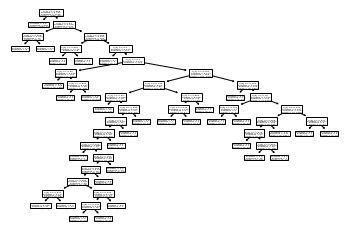

In [14]:
sklearn.tree.plot_tree(clf.fit(Train_X, Train_Y)) 

In [15]:
print(sklearn.metrics.classification_report(Test_Y, clf.predict(Test_X)) )

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       100
           1       0.95      0.95      0.95       100

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



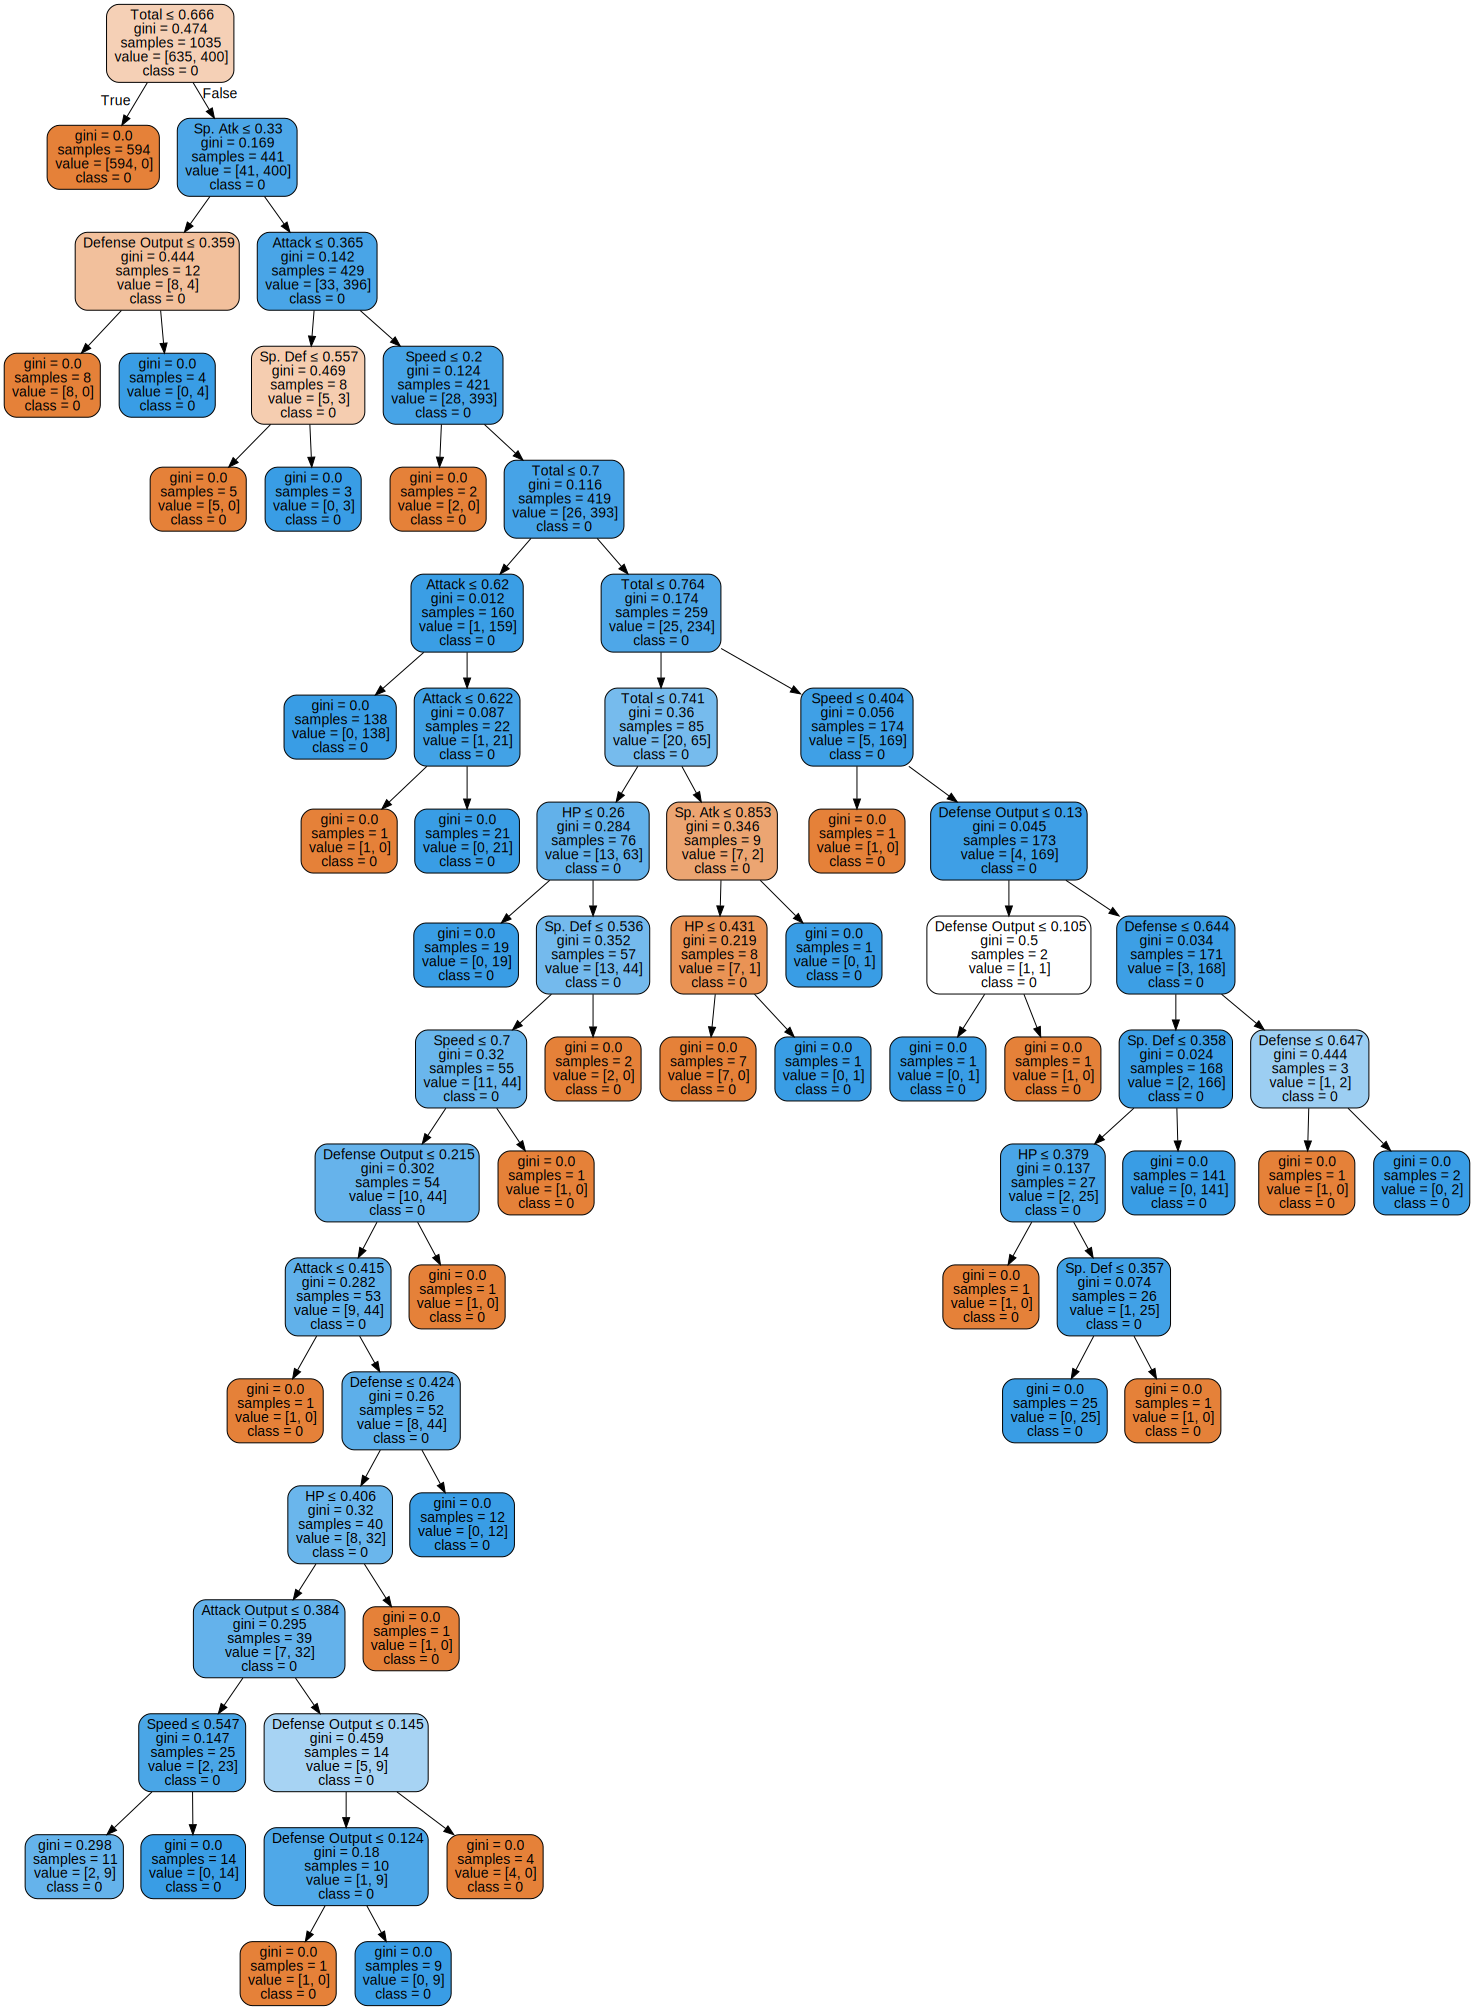

In [18]:
# dot_data = tree.export_graphviz(clf, out_file=None, 
#                      feature_names=iris.feature_names,  
#                      class_names=iris.target_names,  
#                      filled=True, rounded=True,  
#                      special_characters=True) 


dot_data = sklearn.tree.export_graphviz(clf, 
                                        out_file=None,
                                        feature_names=Train_Data.drop(columns = ["Legendary"]).keys().tolist(),
                                        class_names=[",".join(item) for item in Train_Data["Legendary"].astype(str)],
                                        filled=True, 
                                        rounded=True,  
                                        special_characters=True) 
graph = graphviz.Source(dot_data)  
graph 

In [34]:
path = sklearn.tree.export.export_text(clf)
print(path)

|--- feature_0 <= 0.67
|   |--- class: 0
|--- feature_0 >  0.67
|   |--- feature_4 <= 0.33
|   |   |--- feature_8 <= 0.36
|   |   |   |--- class: 0
|   |   |--- feature_8 >  0.36
|   |   |   |--- class: 1
|   |--- feature_4 >  0.33
|   |   |--- feature_2 <= 0.36
|   |   |   |--- feature_5 <= 0.56
|   |   |   |   |--- class: 0
|   |   |   |--- feature_5 >  0.56
|   |   |   |   |--- class: 1
|   |   |--- feature_2 >  0.36
|   |   |   |--- feature_6 <= 0.20
|   |   |   |   |--- class: 0
|   |   |   |--- feature_6 >  0.20
|   |   |   |   |--- feature_0 <= 0.70
|   |   |   |   |   |--- feature_2 <= 0.62
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- feature_2 >  0.62
|   |   |   |   |   |   |--- feature_2 <= 0.62
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- feature_2 >  0.62
|   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  0.70
|   |   |   |   |   |--- feature_0 <= 0.76
|   |   |   |   |   |   |--- feature_0 <= 0.74
|   | 

In [103]:
# export the pdf

pydot_graph = pydotplus.graph_from_dot_data(dot_data)
pydot_graph.write_pdf('original_tree.pdf')
# pydot_graph.set_size('"5,5!"')
# pydot_graph.write_png('resized_tree.png')

True